#Target-aware Dual Adversarial Learning (TarDAL)
-------------------


The paper addresses the issue of fusing infrared and visible images that appear differently for object detection. Aiming at generating an image of high visual quality, which preserves structural information of targets from the infrared and textural details from the visible images. detection-oriented fusion.


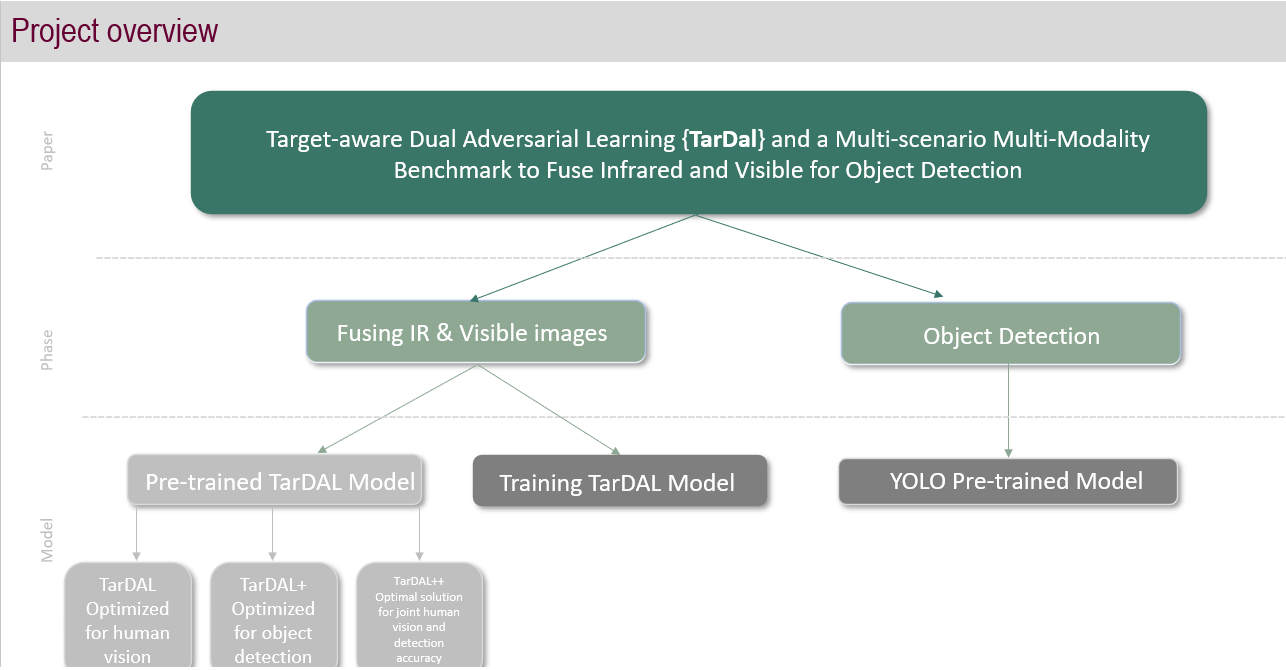



 The target discriminator DT is used to distinguish the foreground thermal
targets of fused result to the infrared while the detail discriminator DD contributes to distinguish the background
details of fused result to the visible.  
The annotation folder of dataset has been used to calculate the target mask m from infrared images so that the two discriminators can perform on their respective regions (target and
background).  
The generator contributes to generate a
fused image that preserves overall structures and maintains
a similar intensity distribution as source images

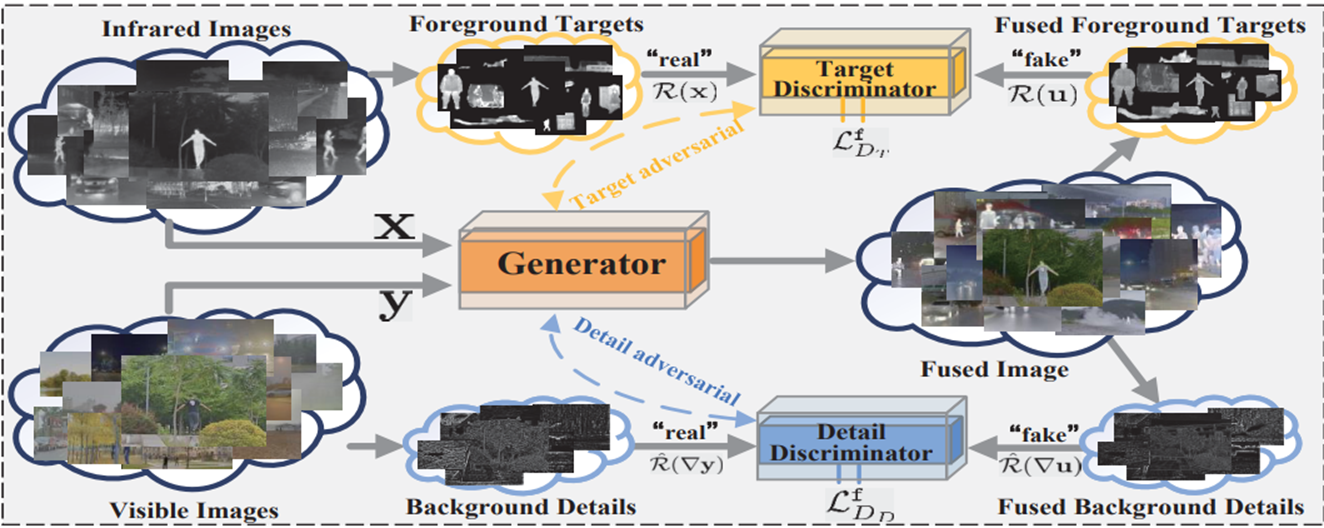

In [1]:
!pip install kornia
!pip install pathlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 KB 8.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import torchvision.transforms as T
import torch.autograd as autograd
from torch import nn, Tensor
from typing import List
from kornia.filters import SpatialGradient
from kornia.losses import SSIMLoss
from kornia.metrics import AverageMeter
from kornia.utils import image_to_tensor
from kornia.utils import tensor_to_image
import numpy as np
from torch.optim import Adam
from tqdm import tqdm
from PIL import Image

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


##Parameter Settings
-------------------



I performed evaluations on 
M3FD dataset which contains 4200 aligned and registered pairs.

1000 images are selected and used random cropping for training the fusion 
task. The tuning parameters of the losses of generator and discriminators α and β are set to
20 and 0.1, respectively. The Adam optimizer updates the
network parameters with the learning rate of 1.0 × 10−4
. The epoch is set to 100 with batch
size of 32

In [4]:
size = 224
latent_dims = 32
epochs = 100
batch_size = 32
learning_rate = 1e-4
num_workers= 2
use_gpu = True
dim = 32
depth = 3
weight=[20, 0.1]#alpha, beta are the trade_off parameters for the losses of the generator and two discriminators
adv_weight=[1, 1]

# Data Loading
-------------------


In [5]:
from google.colab import drive
drive.mount('/content/drive')

folder = Path('/content/drive/MyDrive/M3FD_D')

Mounted at /content/drive


# Create the data set
-------------------

In [6]:
class Dataset(Dataset):
    def __init__(self, folder: Path, transforms=lambda x: x):
        super().__init__()
        self.folder = folder
        self.image_names = (folder / 'list.txt').read_text().splitlines()
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_names)

    def __getitem__(self, index: int) -> dict:
        name = self.image_names[index]
        ir_path = folder / 'ir' / f'{name}.png'
        vi_path = folder / 'vi' / f'{name}.png'
        mk_path = folder / 'mask' / f'{name}.png'
        vsm_ir_path = folder / 'vsm' / 's1' / f'{name}.png'
        vsm_vi_path = folder / 'vsm' / 's2' / f'{name}.png'
        
        ir = self.imread(ir_path)
        vi = self.imread(vi_path)
        mk = self.imread(mk_path)
        s1 = self.imread(vsm_ir_path)
        s2 = self.imread(vsm_vi_path)

        im = torch.cat([ir, vi, mk, s1, s2], dim=0)
        im = self.transforms(im)
        ir, vi, mk, s1, s2 = torch.chunk(im, 5, dim=0)
        
        sample = {'name': name, 'ir': ir, 'vi': vi, 'mk': mk, 'vsm': {'ir': s1, 'vi': s2}}
        return sample
    
    @staticmethod
    def imread(path: Path) -> Tensor:
        img = cv.imread(str(path), cv.IMREAD_GRAYSCALE)
        img = image_to_tensor(img / 255.).float()
        return img


In [ ]:
d = Dataset(folder)
sample = d[1]
print(sample)

{'name': '00001', 'ir': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'vi': tensor([[[0.5059, 0.5216, 0.5294,  ..., 0.5608, 0.5608, 0.5569],
         [0.5020, 0.5176, 0.5255,  ..., 0.5608, 0.5608, 0.5569],
         [0.5020, 0.5216, 0.5216,  ..., 0.5569, 0.5529, 0.5569],
         ...,
         [0.2941, 0.3020, 0.2980,  ..., 0.3137, 0.3137, 0.3137],
         [0.2941, 0.2980, 0.2980,  ..., 0.3098, 0.3137, 0.3176],
         [0.2980, 0.2980, 0.2980,  ..., 0.3137, 0.3137, 0.3216]]]), 'mk': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'vsm': {'ir': tensor([[[0., 0.,

In [7]:
dataset = Dataset(folder,  T.Resize(size))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers= num_workers, pin_memory=True)

#Generator and discriminator architecture
-----------------------




The two discriminators DT and DD share the same network structur.

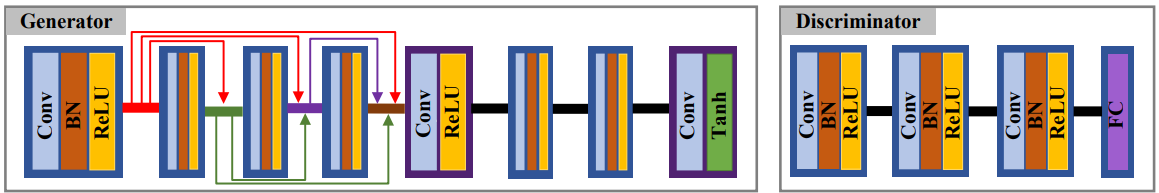

In [8]:
#Use to generate fused images. ir + vi -> fus
class Generator(nn.Module):
    def __init__(self, depth=3):
        super().__init__()
        
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act1 = nn.ReLU()
        
        self.dense_layers = nn.ModuleList([nn.Sequential(
            nn.Conv2d(32 * (i + 1), 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) for i in range(depth)])

        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(32)
        self.act4 = nn.ReLU()
        
        self.conv5 = nn.Conv2d(32, 1, 3, padding=1)
        self.act5 = nn.Tanh()
        
    def forward(self, ir, vi):
        x = torch.cat([ir, vi], dim=1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        for dense in self.dense_layers:
            t = dense(x)
            x = torch.cat([x, t], dim=1)

        x = self.conv2(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.act3(x)  

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.act4(x)
   
        x = self.conv5(x)
        x = self.act5(x)
        
        return x



class Discriminator(nn.Module):
    def __init__(self, dim: int = 32):
        super().__init__()

        self.conv1 = nn.Conv2d(1, dim, (3, 3), (2, 2), 1)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(dim, dim * 2, (3, 3), (2, 2), 1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(dim * 2, dim * 4, (3, 3), (2, 2), 1)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(1064 * 128, 1)

    def forward(self, x: Tensor) -> Tensor:

        x = self.conv1(x)
        x = self.relu1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.flatten(x)
        x = self.linear(x)
        return x

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 296577 and discriminator: 228865


# Training phase
-----------------------

In [15]:
class Tardal:
    
    def __init__(self):
        
        # modules
        self.generator = Generator(depth)
        self.dis_target = Discriminator(dim)
        self.dis_detail = Discriminator(dim)

        # WGAN adam optim
        self.opt_generator = Adam(self.generator.parameters(), lr=learning_rate, betas=(0.5,0.5))
        self.opt_dis_target = Adam(self.dis_target.parameters(), lr=learning_rate, betas=(0.5,0.5))
        self.opt_dis_detail = Adam(self.dis_detail.parameters(), lr=learning_rate, betas=(0.5,0.5))

        # move to device
        self.generator.to(device)
        self.dis_target.to(device)
        self.dis_detail.to(device)

        # loss
        self.l1 = nn.L1Loss(reduction='none')
        self.ssim = SSIMLoss(window_size=11, reduction='none')
        self.l1.cuda()
        self.ssim.cuda()

        # functions
        self.spatial = SpatialGradient('diff')

        # WGAN div hyper parameters
        self.k, self.p = 2, 6

        # Training epochs
        self.epoch = 1

    def train_dis_target(self, ir: Tensor, vi: Tensor, mk: Tensor) -> Tensor:
        """
        Train target discriminator for 'ir * m <- pixel -> fus * m'
        """

       
        # switch to train mode
        self.dis_target.train()

        # sample real & fake
        real_s = ir * mk
        self.generator.eval()
        fake_s = self.generator(ir, vi).detach() * mk

        # judge value towards real & fake
        real_v = torch.squeeze(self.dis_target(real_s))
        fake_v = torch.squeeze(self.dis_target(fake_s))

        # loss calculate
        real_l, fake_l = -real_v.mean(), fake_v.mean()
        a = torch.rand((real_s.shape[0], 1, 1, 1)).cuda()
        x_ = (a * real_s + (1 - a) * fake_s).requires_grad_(True)
        y_ = self.dis_target(x_)
        grad = autograd.grad(
        outputs=y_,
        inputs=x_,
        grad_outputs=torch.ones_like(y_),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
        )[0]
        grad = grad.view(x_.shape[0], -1)
        div = (grad.norm(2, dim=1) ** self.p).mean()

        #div = div_loss(self.dis_target, real_s, fake_s, self.p)
        loss = real_l + fake_l + self.k * div

        # backward
        self.opt_dis_target.zero_grad()
        loss.backward()
        self.opt_dis_target.step()

        return loss.item()

    def train_dis_detail(self, ir: Tensor, vi: Tensor, mk: Tensor) -> Tensor:
        """
        Train detail discriminator for 'vi * (1-m) <- Grad -> fus * (1-m)'
        """

       
        # switch to train mode
        self.dis_detail.train()

        # sample real & fake
        real_s = self.gradient(vi * (1 - mk))
        self.generator.eval()
        fake_s = self.gradient(self.generator(ir, vi).detach() * (1 - mk))

        # judge value towards real & fake
        real_v = torch.squeeze(self.dis_detail(real_s))
        fake_v = torch.squeeze(self.dis_detail(fake_s))

        # loss calculate
        real_l, fake_l = -real_v.mean(), fake_v.mean()
        a = torch.rand((real_s.shape[0], 1, 1, 1)).cuda()
        x_ = (a * real_s + (1 - a) * fake_s).requires_grad_(True)
        y_ = self.dis_detail(x_)
        grad = autograd.grad(
        outputs=y_,
        inputs=x_,
        grad_outputs=torch.ones_like(y_),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
        )[0]
        grad = grad.view(x_.shape[0], -1)
        div = (grad.norm(2, dim=1) ** self.p).mean()
        #div = div_loss(self.dis_detail, real_s, fake_s, self.p)
        loss = real_l + fake_l + self.k * div

        # backward
        self.opt_dis_detail.zero_grad()
        loss.backward()
        self.opt_dis_detail.step()

        return loss.item()

    def gradient(self, x: Tensor, eps: float = 1e-6) -> Tensor:
        s = self.spatial(x)
        dx, dy = s[:, :, 0, :, :], s[:, :, 1, :, :]
        u = torch.sqrt(torch.pow(dx, 2) + torch.pow(dy, 2) + eps)
        return u

    def train_generator(self, ir: Tensor, vi: Tensor, mk: Tensor, s1: Tensor, s2: Tensor) -> dict:
        """
        Train generator 'ir + vi -> fus'
        """

        
        self.generator.train()
        fus = self.generator(ir, vi)

        # calculate loss towards criterion
        alpha, beta = weight  # ssim + alpha * l1 + beta * adv

        l_ir = self.ssim(fus, ir) + alpha * self.l1(fus, ir)
        l_vi = self.ssim(fus, vi) + alpha * self.l1(fus, vi)

        w1, w2 = 0.5 + 0.5 * (s1 - s2), 0.5 + 0.5 * (s2 - s1)  # data driven loss weights
        l_src = w1 * l_ir + w2 * l_vi  # fus <- ssim + l1 -> (ir, vi)
        l_src = l_src.mean()

        self.dis_target.eval()
        l_target = -self.dis_target(fus * mk).mean()  # judge target: fus * m
        self.dis_detail.eval()
        l_detail = -self.dis_detail(self.gradient(fus * (1 - mk))).mean()  # judge detail: Grad(fus * (1-mk))

        c1, c2 = adv_weight  # c1 * l_target + c2 * l_detail
        l_adv = c1 * l_target + c2 * l_detail

        loss = l_src + beta * l_adv

        # backward
        self.opt_generator.zero_grad()
        loss.backward()
        self.opt_generator.step()

        # loss state
        state = {
            'g_loss': loss.item()
           }
        return state
    def train(self, epochs):
        last_epoch = self.epoch + epochs
        self.d_detail_loss = []
        self.d_target_loss = []
        self.g_loss = []

        # Number of iterations per epoch
        self.num_iterations = len(dataloader)
        
        while self.epoch < last_epoch:
            process = tqdm(enumerate(dataloader))
            meter = AverageMeter()
            for idx, sample in process:
                ir, vi, mk = sample['ir'], sample['vi'], sample['mk']
                s1, s2 = sample['vsm']['ir'], sample['vsm']['vi']
                im = torch.cat([ir, vi, mk, s1, s2], dim=1)
                im = im.to(device)
                ir, vi, mk, s1, s2 = torch.chunk(im, 5, dim=1)

                #  Train Generator
                g_loss = self.train_generator(ir, vi, mk, s1, s2)
                # Train the discriminators
                d_target_loss = self.train_dis_target(ir, vi, mk)
                d_detail_loss = self.train_dis_detail(ir, vi, mk)

                self.g_loss.append(g_loss['g_loss'])
                self.d_target_loss.append(d_target_loss)
                self.d_detail_loss.append(d_detail_loss)

                process.set_description(f'Epoch: {self.epoch} | Iteration: {idx + 1}/{self.num_iterations} | g_loss: {g_loss["g_loss"]:03f} | d_target_loss: {d_target_loss:03f} | d_detail_loss: {d_detail_loss:03f}')
                meter.update(Tensor(list(g_loss.values()) + [d_target_loss] + [d_detail_loss]))

                # Check if the current iteration is the last one in the current epoch
                if idx + 1 == self.num_iterations:
                    self.epoch += 1



                  #save the model
            torch.save(self.generator.state_dict(), folder / 'MyTarDAL1.pth')  

## Create the TarDAL
-----------------------


In [16]:
tardal = Tardal()

## Train the TarDAL
-----------------------

In [17]:
tardal.train(epochs = 100)

Epoch: 1 | Iteration: 32/32 | g_loss: 2.089185 | d_target_loss: -1.082613 | d_detail_loss: -1.461282: : 32it [01:58,  3.71s/it]
Epoch: 2 | Iteration: 32/32 | g_loss: 1.264493 | d_target_loss: -0.467635 | d_detail_loss: -0.147264: : 32it [01:59,  3.73s/it]
Epoch: 3 | Iteration: 32/32 | g_loss: 1.918616 | d_target_loss: -0.037526 | d_detail_loss: -0.444805: : 32it [01:56,  3.63s/it]
Epoch: 4 | Iteration: 32/32 | g_loss: 2.480466 | d_target_loss: -0.685080 | d_detail_loss: -0.194120: : 32it [01:57,  3.68s/it]
Epoch: 5 | Iteration: 32/32 | g_loss: 2.508774 | d_target_loss: -2.565711 | d_detail_loss: -0.317604: : 32it [01:56,  3.63s/it]
Epoch: 6 | Iteration: 32/32 | g_loss: 2.032427 | d_target_loss: 0.231569 | d_detail_loss: -0.356957: : 32it [01:58,  3.69s/it]
Epoch: 7 | Iteration: 32/32 | g_loss: 2.300714 | d_target_loss: -2.100539 | d_detail_loss: -0.439784: : 32it [01:56,  3.64s/it]
Epoch: 8 | Iteration: 32/32 | g_loss: 1.906791 | d_target_loss: -1.569703 | d_detail_loss: -0.344277: : 3

## Plot losses
-----------------------


L
f = LSSIM + αLpixel + βL
adv
f

where LSSIM denotes structure similarity loss. To balance the pixel intensity distribution of source images,
they introduce a pixel loss based on the saliency degree
weight (SDW). 
The adversarial loss functions of these discriminators
calculate the Wasserstein divergence to mutually identify
whether the foreground thermal targets and background texture details are realistic

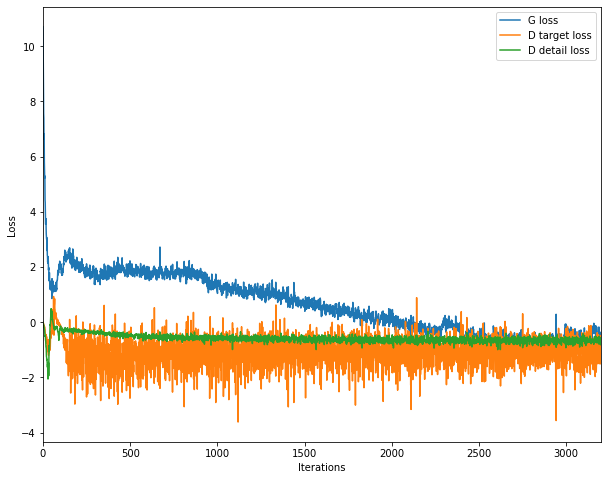

In [20]:

fig = plt.figure(figsize=(10, 8))
plt.xlim(0,3200)
plt.plot(tardal.g_loss, label='G loss')
plt.plot(tardal.d_target_loss, label='D target loss')
plt.plot(tardal.d_detail_loss, label='D detail loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

##Loading pre-trained TarDAL
-----------------------

In [14]:
net = Generator()
net.load_state_dict(torch.load(folder/'MyTarDAL1.pth'))# tardal could be replaced with tardal+ or tardal++
print('done')

done


# Fusing infrared and visible images using the trained model
-----------------------

In [15]:
class fuse:
  def __init__(self, net):
    self.net = net
    self.transform = T.Compose([T.ToTensor()])

  def __call__(self, ir_paths: List[Path], vi_paths: List[Path], dst: Path, color: bool = True):
    print('Fusing...', end='')
    for ir_path, vi_path in zip(ir_paths, vi_paths):
        
        ir_c = np.array(Image.open(ir_path).convert('L'))
        vi_c = np.array(Image.open(vi_path))

        ir_tensor = self.transform(ir_c / 255.).float()
        vi_tensor = self.transform(cv.cvtColor(vi_c, cv.COLOR_BGR2GRAY) / 255.).float()

        fus = self.net(ir_tensor.unsqueeze(0), vi_tensor.unsqueeze(0)).clip(0., 1.)
        fus = fus.squeeze().detach().numpy() * 255.
        fus = fus.astype(np.uint8)
        cbcr = cv.cvtColor(vi_c, cv.COLOR_BGR2YCrCb)[:, :, -2:]
        fus_r = np.concatenate([fus[..., np.newaxis], cbcr], axis=2)
        fus_c = cv.cvtColor(fus_r, cv.COLOR_YCrCb2BGR)
        cv.imwrite(str(dst / ir_path.name), fus_c)
    print('\r                            \r', end='')
    print('Fused image is saved')

In [16]:
Filenum = 711 #@param {type:"slider", min:100, max:999, step:1}
FileName = '00'+ str(Filenum) + '.png'
Dst = folder / 'dst'
Fuse = fuse(net)
Fuse([folder/ 'ir'/ FileName], [folder/ 'vi'/ FileName], Dst)

Fused image is saved


# Generated images
-----------------------

Text(0.5, 1.0, 'Fused')

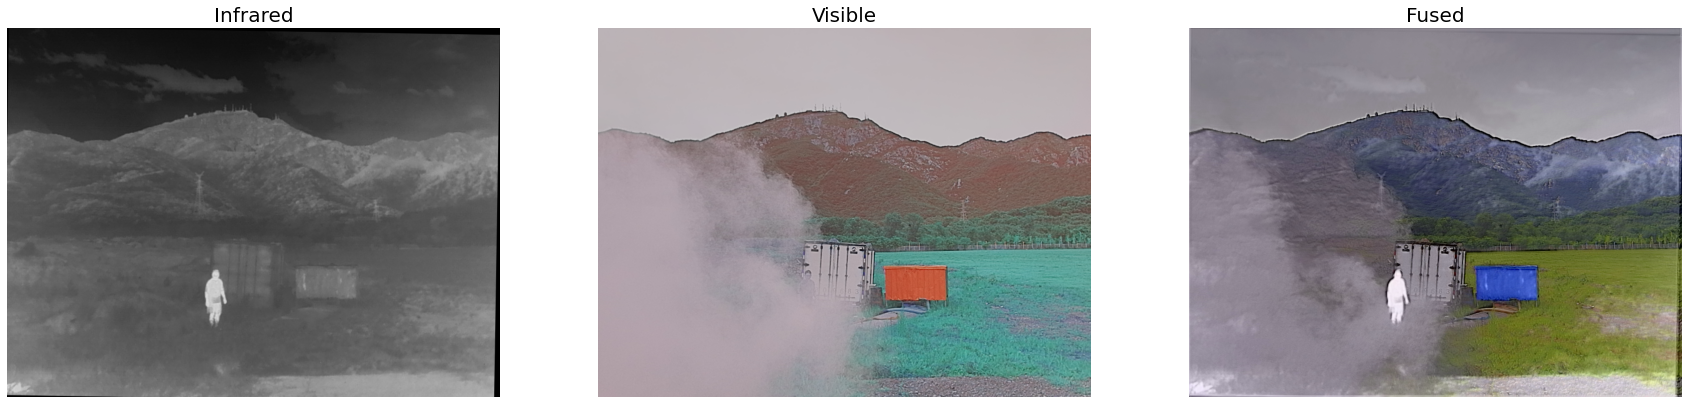

In [17]:
# display sample
# create figure
fig = plt.figure(figsize=(30, 21))
  
# setting values to rows and column variables
rows = 1
columns = 3
  
# reading images
Image1 = cv.imread(str(folder)+ "/ir/" + FileName)
Image2 = cv.imread(str(folder)+ "/vi/" + FileName)
Fused_img = cv.imread(str(folder)+ "/dst/" + FileName, cv.IMREAD_COLOR)

  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Infrared", fontsize = 20)
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Visible", fontsize = 20)
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(Fused_img)
plt.axis('off')
plt.title("Fused", fontsize = 20)

# Object detection using YOLO
-----------------------

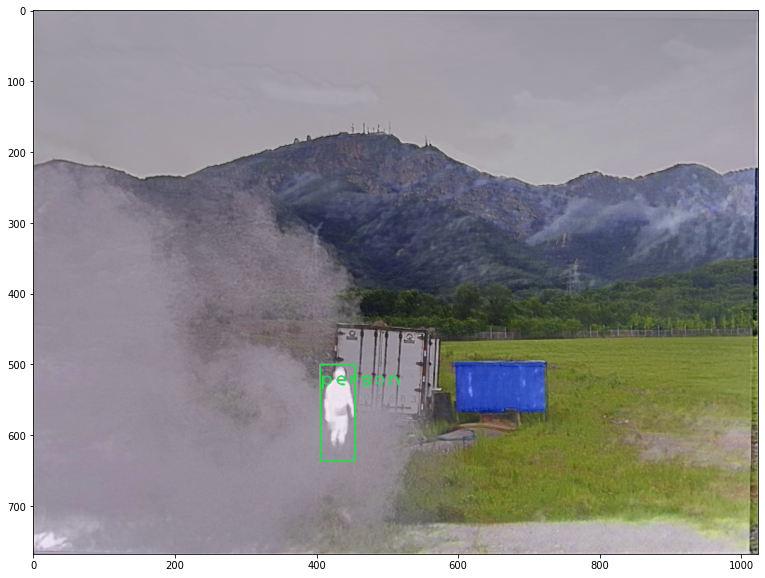

In [24]:
yolo_path = '/content/drive/MyDrive/M3FD_D/YOLO'
classes = []
with open(yolo_path + '/' + "coco.names", "r") as f:
     classes = [line.strip() for line in f.readlines()]

yolo_net = cv.dnn.readNet((yolo_path + '/' + "yolov3.weights"), (yolo_path + '/' + "yolov3.cfg"))  
layer_names = yolo_net.getLayerNames()
output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]      
height, width, channels = Fused_img.shape
img_blob = cv.dnn.blobFromImage(Fused_img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
yolo_net.setInput(img_blob)
outputs = yolo_net.forward(output_layers)
class_ids = []
confidences = []
boxes = []
for out in outputs:
  for detection in out:
    scores = detection[5:]
    class_id = np.argmax(scores)
    confidence = scores[class_id]
    if confidence> 0.4:
      center_x = int(detection[0] * width)
      center_y = int(detection[1] * height)
      w = int(detection[2] * width)
      h = int(detection[3] * height)
      # Rectangle coordinates
      x = int(center_x - w / 2)
      y = int(center_y - h / 2)
      boxes.append([x, y, w, h])
      confidences.append(float(confidence))
      class_ids.append(class_id)

colors = np.random.uniform(0, 255, size=(len(classes), 3))
indexes = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
for i in range(len(boxes)):
  if i in indexes:
    x, y, w, h = boxes[i]
    label = str(classes[class_ids[i]])
    color = colors[class_ids[i]]
    cv.rectangle(Fused_img, (x, y), (x + w, y + h), color, 2)
    cv.putText(Fused_img, label, (x, y + 30), cv.FONT_HERSHEY_PLAIN, 2, color, 2)
    cv.imwrite(yolo_path + '/' + FileName ,Fused_img)   

#showing the detected objects in the fused image
detected_img = cv.imread(yolo_path + '/' + FileName)
fig = plt.figure(figsize=(15, 10))
plt.imshow(detected_img)